In [47]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
import math
from math import log
import matplotlib.pyplot as plt

# import sklearn
# from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

# from sklearn import metrics 
# from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# from sklearn.ensemble import RandomForestClassifier

# from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [48]:
#Trigger point to be set whenever a new part is processed(new observations is available to us)

In [49]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\AAM\False Rejects")

In [50]:
df=pd.read_pickle(os.getcwd()+"\Data Files\Transformed_NVH_DATA.pkl")

In [51]:
df.head(5)

CHARDESC,SITENAME,LINENAME,STATIONNAME,PARTNUMBER,STATUS,TOPLEVELSERIALNUMBER,PROD_TIMESTAMP,COLLID,LH Slide To Full Depth Posn,NVH Torque Sweep Test Cycle Count,Pinion Slide To Full Depth Posn,RH Slide To Full Depth Posn,FALSE_REJECT
12,GMCFULL,T1XX Front Axle FA HiV,OP180A,40217205,A,01A192630807,2020-03-26 08:18:37.623,-1254007092,1095.29,1.0,245.400,1498.46,0
13,GMCFULL,T1XX Front Axle FA HiV,OP180A,40217205,A,01A192660476,2020-03-26 08:20:27.887,-1254006657,1095.39,1.0,245.607,1498.17,0
14,GMCFULL,T1XX Front Axle FA HiV,OP180A,40217205,A,01A192660506,2020-03-26 08:14:33.793,-1254007456,1095.69,1.0,245.698,1498.30,0
15,GMCFULL,T1XX Front Axle FA HiV,OP180A,40217205,A,01A192660555,2020-03-26 08:16:38.367,-1254007093,1095.20,1.0,245.470,1497.36,0
18264,GMCFULL,T1XX Front Axle FA HiV,OP180A,40217205,A,01A200630110,2020-06-05 00:45:35.833,-1251008204,1095.40,1.0,246.075,1497.79,0


### Filter out the data for stationname = 'OP180B'

In [52]:
df.sort_values(by = 'PROD_TIMESTAMP', inplace = True)

df = df[df["STATIONNAME"]=="OP180A"]

In [53]:
df["PROD_DAY"]=df["PROD_TIMESTAMP"].apply(lambda x: pd.datetime(x.year,x.month,x.day))

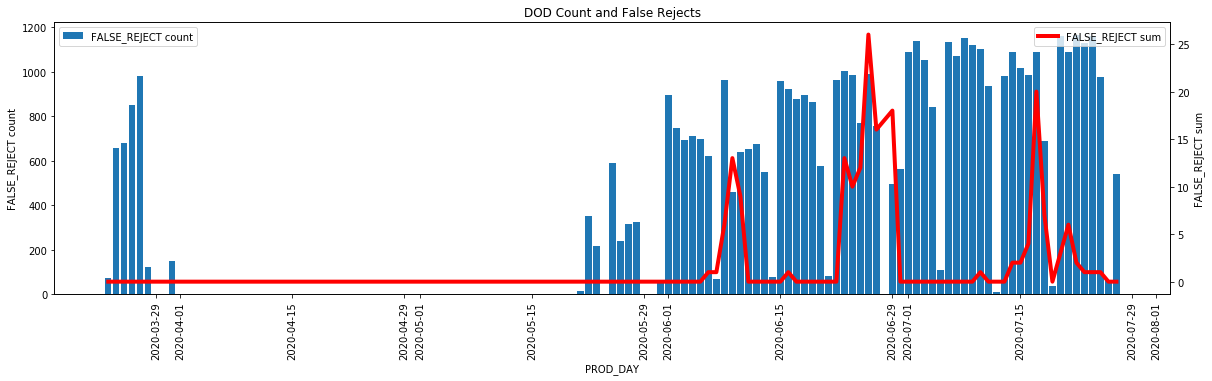

In [54]:
df_dod = df[["PROD_DAY","FALSE_REJECT"]].groupby("PROD_DAY").agg(["sum","count"]).reset_index()
df_dod.columns = [' '.join(col).strip() for col in df_dod.columns.values]

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(df_dod["PROD_DAY"],df_dod["FALSE_REJECT count"], label = 'FALSE_REJECT count')
plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT count')
plt.legend(loc="best")
plt.xticks(rotation = 90,)
ax2 = ax1.twinx()
ax2.plot(df_dod["PROD_DAY"],df_dod["FALSE_REJECT sum"],color='red', linewidth=4, markersize=12, label = 'FALSE_REJECT sum')
plt.title("DOD Count and False Rejects")
plt.legend(loc="best")


plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT sum')

plt.show()
# ax1.plot()

# df_dod.plot(x="PROD_DAY", y = ["FALSE_REJECT sum","FALSE_REJECT count"])

In [55]:
df= df[(df["PROD_TIMESTAMP"]>=pd.datetime(2020,5,22))&(df["PROD_TIMESTAMP"]<=pd.datetime(2020,7,30))]

In [56]:
df.reset_index(drop=True, inplace = True)

# Feature Engineering

### New Features:
1) Abnormality Flag (For Supervised Approachs) 

2) Mean Shift(Ratio or Difference b/w current 30 obs to baseline obs) (Especially for Pinion Depth) -ve signifies high false rejects (Useful especially for distance based anamoly detection techniques)

3) Decontamination Flag 

4) Throughput rate (might have impact on value of pinion depth maybe)

5) Week day, Hour

6) False reject rate in last 30,60,90 observation (More observations will lead to more stable results, higher(more distinct peaks) but higher time to detect)

7) Benchmark rates for comparison for 2000 data points from past (Both normal and decontaminated)

8) Begining and end point of anomalous behaviour

9) Average of pinion depth over last 30,60 observations. Likewise for LH and RH features

Other Notes:
Recent observations can be assigned higher weihts, especially for statistical approaches
Date time is contextual attribute. Remaining all are behavioural attributes.

In [57]:
df["ABNORMALITY_FLAG"]=np.where(((df.PROD_TIMESTAMP>=pd.datetime(2020,6,6,12)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,6,10,5)))
                            | ((df.PROD_TIMESTAMP>=pd.datetime(2020,6,23,5)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,6,27,1)))
                            | ((df.PROD_TIMESTAMP>=pd.datetime(2020,7,16,10)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,7,18,19)))  
                                ,1,0)

In [83]:
df["ABNORMALITY_WINDOW"]=np.where(((df.PROD_TIMESTAMP>=pd.datetime(2020,6,6,12)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,6,10,5))),1,
                            np.where( ((df.PROD_TIMESTAMP>=pd.datetime(2020,6,23,5)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,6,27,1))),2,
                           np.where( ((df.PROD_TIMESTAMP>=pd.datetime(2020,7,16,10)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,7,18,19))),3,'Others')))

In [58]:
df["FP_500_C"] = df.FALSE_REJECT.rolling(window = 500,min_periods = 1, center = True).mean()

In [59]:
df["PROD_HOUR"]=df["PROD_TIMESTAMP"].apply(lambda x: pd.datetime(x.year,x.month,x.day,math.floor(x.hour/6)*6))

In [60]:
df["DECONTAMINATION_FLAG"]=np.where(df["FP_500_C"]>0.002,1,0)

In [61]:
df.groupby("DECONTAMINATION_FLAG")['FALSE_REJECT'].agg(["mean","count","sum"])

,mean,count,sum
DECONTAMINATION_FLAG,,,
0,0.000261,34513,9
1,0.014389,11606,167


In [62]:
df_hour = df[["PROD_HOUR","ABNORMALITY_FLAG","FALSE_REJECT","FP_500_C"]].groupby("PROD_HOUR").agg(["mean"])

df_hour.columns = [' '.join(col).strip() for col in df_hour.columns.values]

df_hour.reset_index(inplace = True)

(array([737574., 737577., 737591., 737605., 737607., 737621., 737635.]),
 <a list of 7 Text xticklabel objects>)

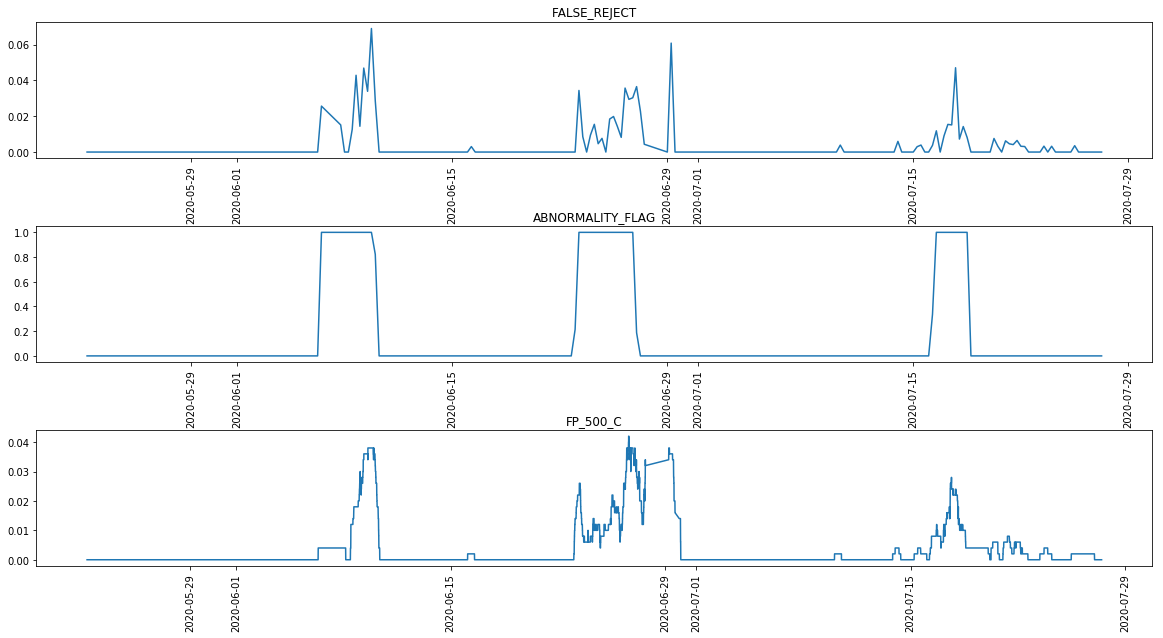

In [63]:
df1= df_hour[df_hour["PROD_HOUR"]>=pd.datetime(2020,5,20)]


fig = plt.figure(figsize = (20,10))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(3,1,1)
ax1.plot(df1["PROD_HOUR"],df1["FALSE_REJECT mean"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(3,1,2)
ax1.plot(df1["PROD_HOUR"],df1["ABNORMALITY_FLAG mean"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(3,1,3)
ax1.plot(df["PROD_TIMESTAMP"],df["FP_500_C"])
plt.title("FP_500_C")
plt.xticks(rotation = 90,)


In [64]:
df["DAY_OF_WEEK"] = df.PROD_TIMESTAMP.dt.dayofweek
df["HOUR"] = df.PROD_TIMESTAMP.dt.hour

In [65]:
df["FP_30_MEAN"] = df.FALSE_REJECT.rolling(window = 30,min_periods = 1, center = False).mean()

df["FP_60_MEAN"] = df.FALSE_REJECT.rolling(window = 60,min_periods = 1, center = False).mean()

df["FP_200_MEAN"] = df.FALSE_REJECT.rolling(window = 200,min_periods = 1, center = False).mean()

df["FP_500_MEAN"] = df.FALSE_REJECT.rolling(window = 500,min_periods = 1, center = False).mean()

df["FP_30_SD"] = df.FALSE_REJECT.rolling(window = 30,min_periods = 1, center = False).std()

df["FP_60_SD"] = df.FALSE_REJECT.rolling(window = 60,min_periods = 1, center = False).std()

df["FP_200_SD"] = df.FALSE_REJECT.rolling(window = 200,min_periods = 1, center = False).std()

df["FP_500_SD"] = df.FALSE_REJECT.rolling(window = 500,min_periods = 1, center = False).std()

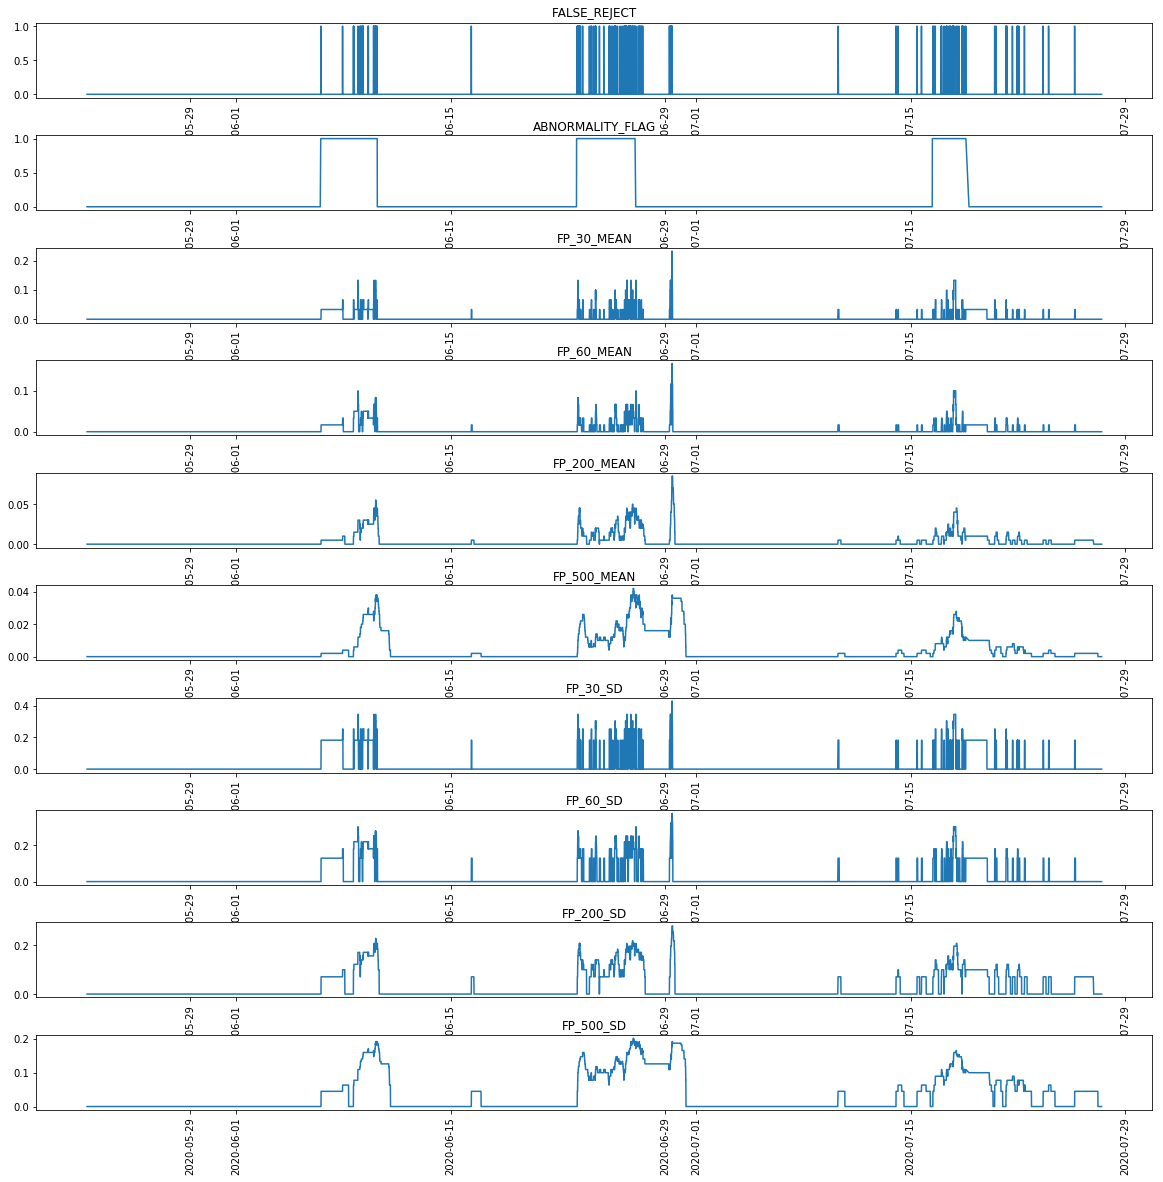

In [66]:
df1= df[df["PROD_TIMESTAMP"]>=pd.datetime(2020,5,20)]


fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(10,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(10,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

columns = ["FP_30_MEAN","FP_60_MEAN","FP_200_MEAN","FP_500_MEAN","FP_30_SD","FP_60_SD","FP_200_SD","FP_500_SD"]

for x in range(len(columns)):
    
    ax1= fig.add_subplot(10,1,x+3)
    ax1.plot(df["PROD_TIMESTAMP"],df[columns[x]])
    plt.title(columns[x])
    plt.xticks(rotation = 90,)

In [67]:
df["PINION_DEPTH_30_MEAN"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()

df["PINION_DEPTH_60_MEAN"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 60,min_periods = 1, center = False).mean()

df["PINION_DEPTH_200_MEAN"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 200,min_periods = 1, center = False).mean()

df["PINION_DEPTH_500_MEAN"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 500,min_periods = 1, center = False).mean()

df["PINION_DEPTH_30_SD"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).std()

df["PINION_DEPTH_60_SD"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 60,min_periods = 1, center = False).std()

df["PINION_DEPTH_200_SD"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 200,min_periods = 1, center = False).std()

df["PINION_DEPTH_500_SD"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 500,min_periods = 1, center = False).std()

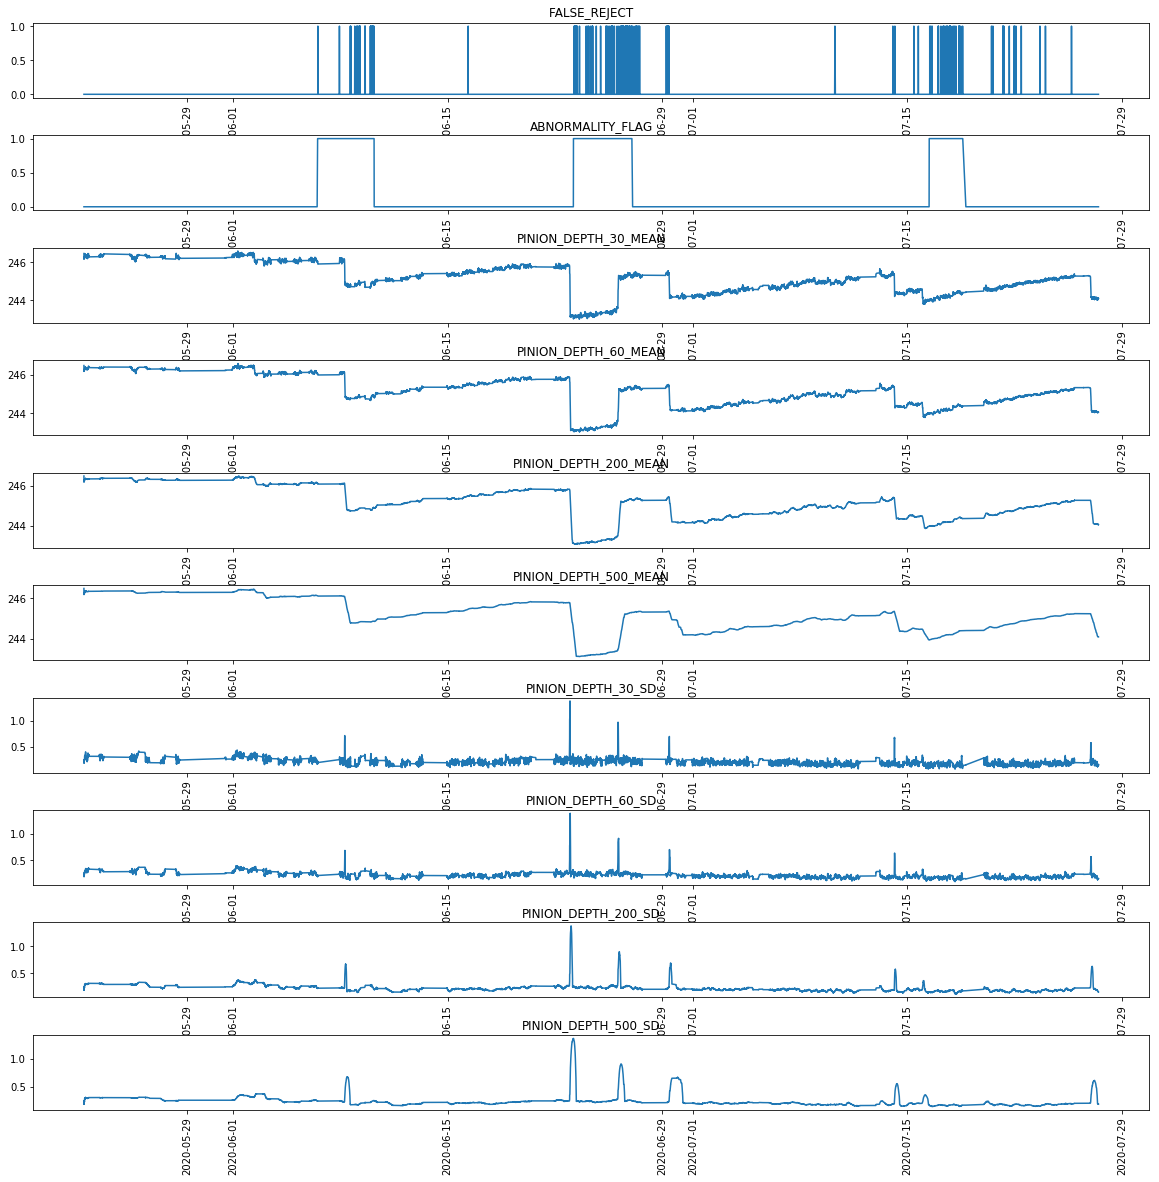

In [68]:
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(10,1,1)
ax1.plot(df["PROD_TIMESTAMP"],df["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(10,1,2)
ax1.plot(df["PROD_TIMESTAMP"],df["ABNORMALITY_FLAG"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

columns = ["PINION_DEPTH_30_MEAN","PINION_DEPTH_60_MEAN","PINION_DEPTH_200_MEAN","PINION_DEPTH_500_MEAN","PINION_DEPTH_30_SD","PINION_DEPTH_60_SD","PINION_DEPTH_200_SD","PINION_DEPTH_500_SD"]

for x in range(len(columns)):
    
    ax1= fig.add_subplot(10,1,x+3)
    ax1.plot(df["PROD_TIMESTAMP"],df[columns[x]])
    plt.title(columns[x])
    plt.xticks(rotation = 90,)

In [69]:
df["LH_30_MEAN"] = df["LH Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()

df["LH_60_MEAN"] = df["LH Slide To Full Depth Posn"].rolling(window = 60,min_periods = 1, center = False).mean()

df["LH_200_MEAN"] = df["LH Slide To Full Depth Posn"].rolling(window = 200,min_periods = 1, center = False).mean()

df["LH_500_MEAN"] = df["LH Slide To Full Depth Posn"].rolling(window = 500,min_periods = 1, center = False).mean()

df["LH_30_SD"] = df["LH Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).std()

df["LH_60_SD"] = df["LH Slide To Full Depth Posn"].rolling(window = 60,min_periods = 1, center = False).std()

df["LH_200_SD"] = df["LH Slide To Full Depth Posn"].rolling(window = 200,min_periods = 1, center = False).std()

df["LH_500_SD"] = df["LH Slide To Full Depth Posn"].rolling(window = 500,min_periods = 1, center = False).std()

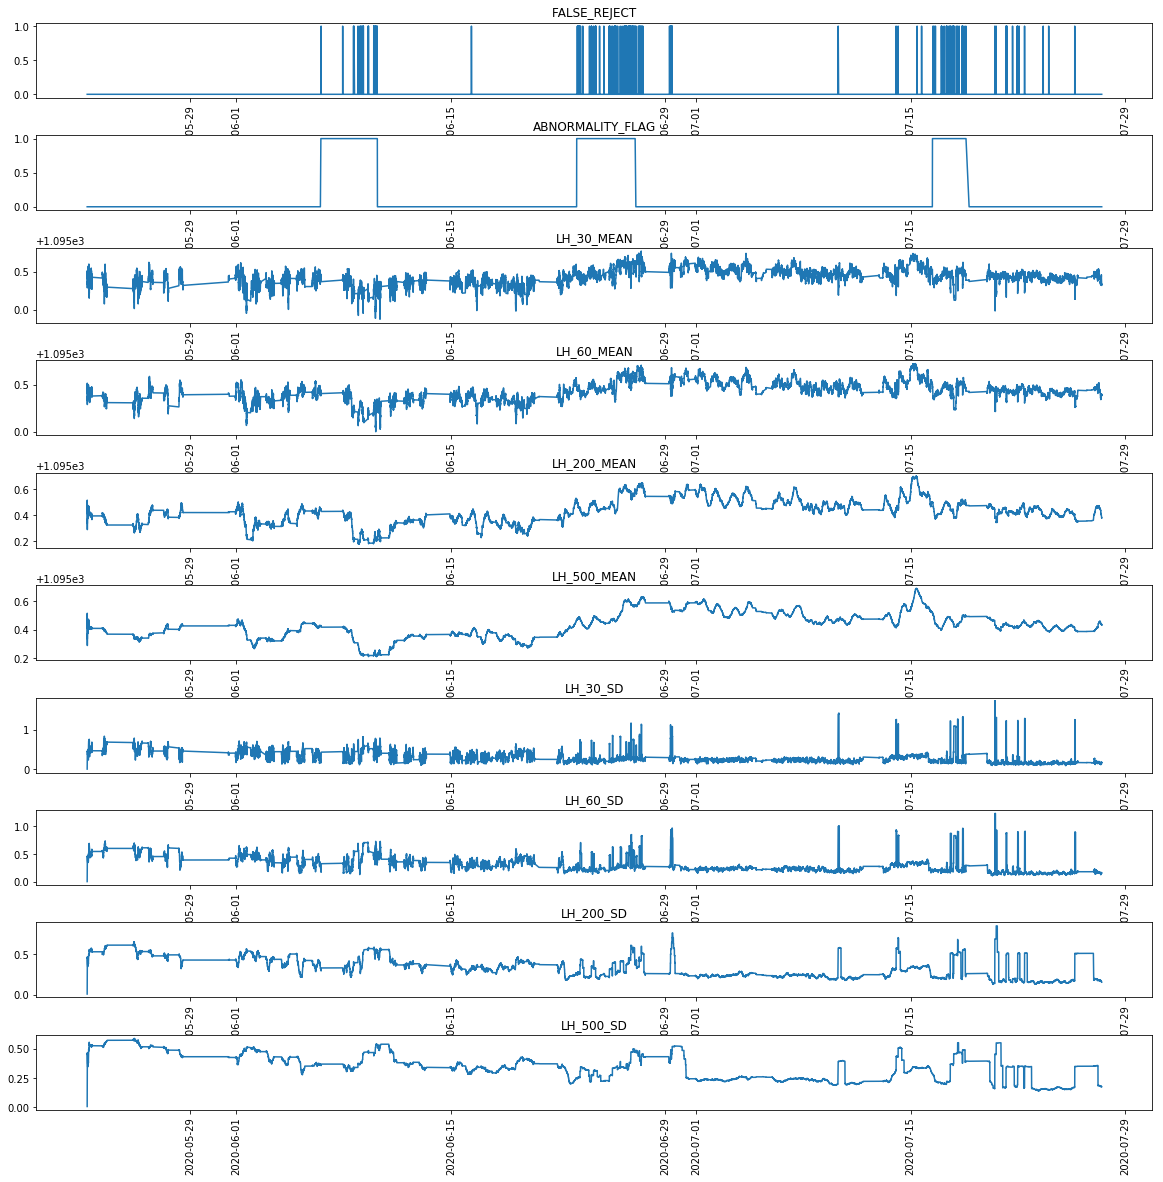

In [70]:
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(10,1,1)
ax1.plot(df["PROD_TIMESTAMP"],df["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(10,1,2)
ax1.plot(df["PROD_TIMESTAMP"],df["ABNORMALITY_FLAG"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

columns = ["LH_30_MEAN","LH_60_MEAN","LH_200_MEAN","LH_500_MEAN","LH_30_SD","LH_60_SD","LH_200_SD","LH_500_SD"]

for x in range(len(columns)):
    
    ax1= fig.add_subplot(10,1,x+3)
    ax1.plot(df["PROD_TIMESTAMP"],df[columns[x]])
    plt.title(columns[x])
    plt.xticks(rotation = 90,)

In [71]:
df["RH_30_MEAN"] = df["RH Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()

df["RH_60_MEAN"] = df["RH Slide To Full Depth Posn"].rolling(window = 60,min_periods = 1, center = False).mean()

df["RH_200_MEAN"] = df["RH Slide To Full Depth Posn"].rolling(window = 200,min_periods = 1, center = False).mean()

df["RH_500_MEAN"] = df["RH Slide To Full Depth Posn"].rolling(window = 500,min_periods = 1, center = False).mean()


df["RH_30_SD"] = df["RH Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).std()

df["RH_60_SD"] = df["RH Slide To Full Depth Posn"].rolling(window = 60,min_periods = 1, center = False).std()

df["RH_200_SD"] = df["RH Slide To Full Depth Posn"].rolling(window = 200,min_periods = 1, center = False).std()

df["RH_500_SD"] = df["RH Slide To Full Depth Posn"].rolling(window = 500,min_periods = 1, center = False).std()



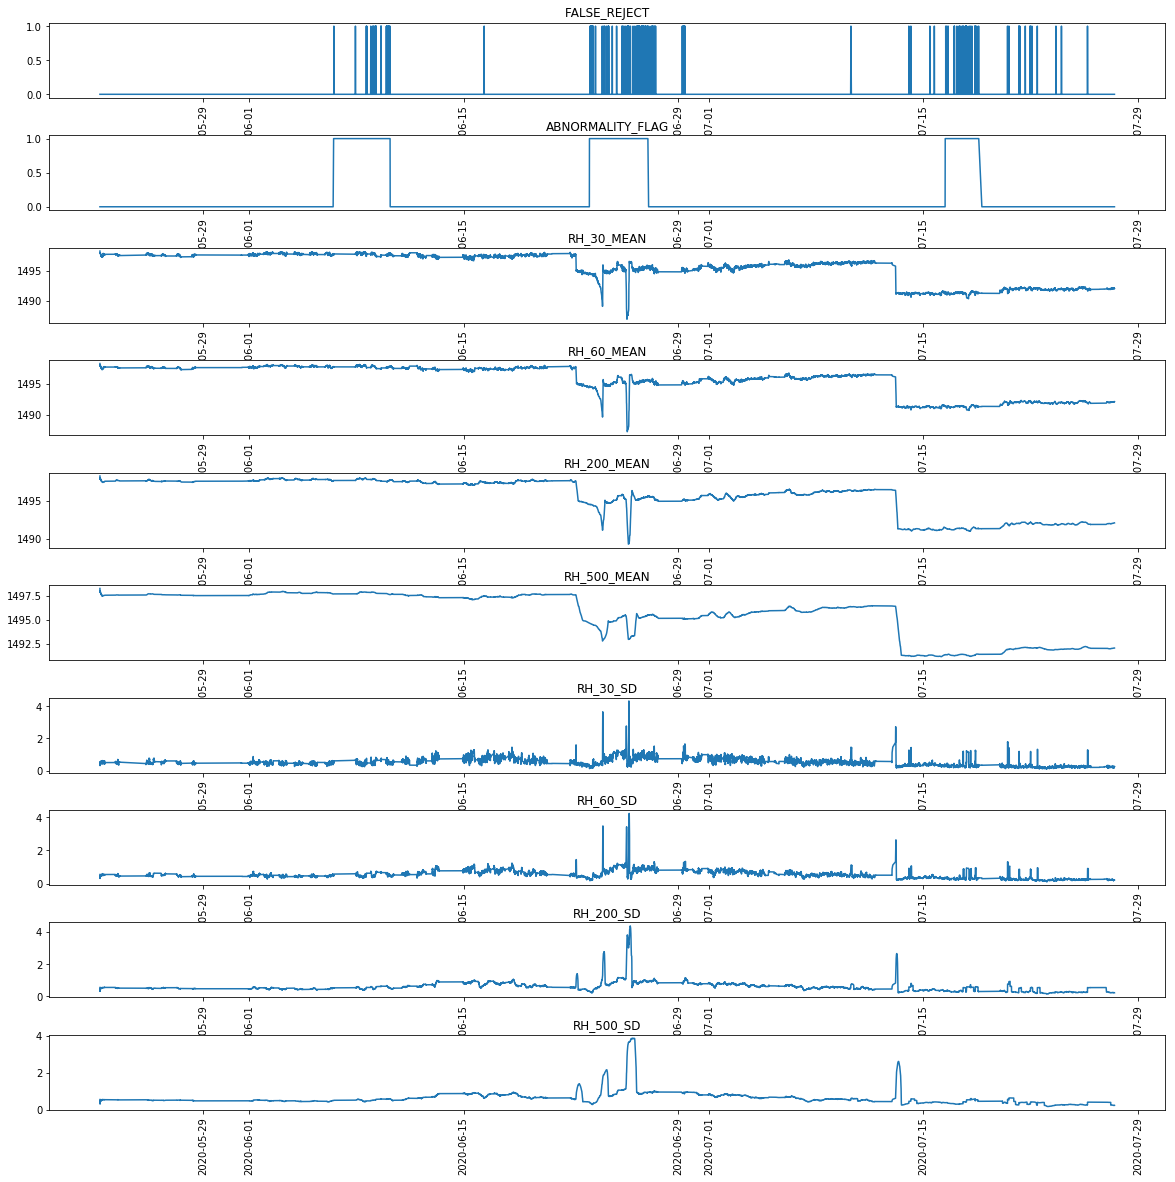

In [72]:
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(10,1,1)
ax1.plot(df["PROD_TIMESTAMP"],df["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(10,1,2)
ax1.plot(df["PROD_TIMESTAMP"],df["ABNORMALITY_FLAG"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

columns = ["RH_30_MEAN","RH_60_MEAN","RH_200_MEAN","RH_500_MEAN","RH_30_SD","RH_60_SD","RH_200_SD","RH_500_SD"]

for x in range(len(columns)):
    
    ax1= fig.add_subplot(10,1,x+3)
    ax1.plot(df["PROD_TIMESTAMP"],df[columns[x]])
    plt.title(columns[x])
    plt.xticks(rotation = 90,)

In [73]:
# Based on 10 observations (Parts/Hour)
df["THROUGHPUT_RATE"] = round(20/(df.PROD_TIMESTAMP-df.PROD_TIMESTAMP.shift(20)).dt.seconds*3600)

(array([737574., 737577., 737591., 737605., 737607., 737621., 737635.]),
 <a list of 7 Text xticklabel objects>)

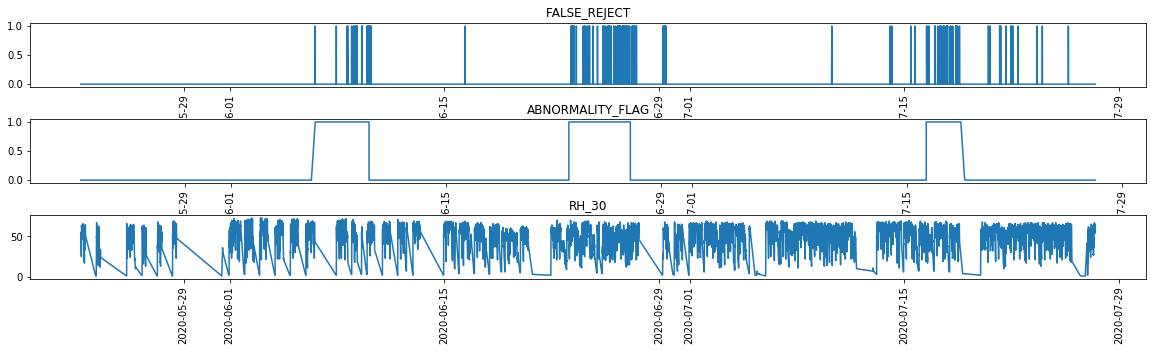

In [74]:
df1= df[df["PROD_TIMESTAMP"]>=pd.datetime(2020,5,20)]


fig = plt.figure(figsize = (20,10))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(6,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(6,1,2)
ax1.plot(df1["PROD_HOUR"],df1["ABNORMALITY_FLAG"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(6,1,3)
ax1.plot(df["PROD_TIMESTAMP"],df["THROUGHPUT_RATE"])
plt.title("RH_30")
plt.xticks(rotation = 90,)


In [75]:
# df.reset_index(inplace = True, drop = True)

# # x= 20000
# b_window = 2000
# c_window = 30


# # df.shape[0]
# start = time.time()

# for x in range(b_window,df.shape[0]):
    
#     base_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     current_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-c_window):x])
#     ks_value = ks_2samp(base_obs,current_obs)
# #     ks_value = ks_2samp([0] * 10000,current_obs)
#     df.loc[df.index[x],"DIFF_VAR1"] = 1-ks_value.pvalue

# print (time.time()-start)

In [76]:
df.reset_index(inplace = True, drop = True)

# x= 20000
b_window = 4000
c_window = 500

df["FP_30_MEAN"] = df.FALSE_REJECT.rolling(window = 30,min_periods = 1, center = False).mean()
df["PINION_DEPTH_30_MEAN"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()
df["LH_30_MEAN"] = df["LH Slide To Full Depth Posn"]
df["RH_30_MEAN"] = df["RH Slide To Full Depth Posn"]


# df.shape[0]
start = time.time()

for x in range(b_window,df.shape[0]):
    
    base_obs = df[["DECONTAMINATION_FLAG","FALSE_REJECT","Pinion Slide To Full Depth Posn",
                        "LH Slide To Full Depth Posn","RH Slide To Full Depth Posn"]][max(0,x-b_window-c_window):max(0,x-c_window)]
    
#     base_obs_FP = list(df["FALSE_REJECT"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     base_obs_PINION_DEPTH = list(df["Pinion Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     base_obs_LH = list(df["LH Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     base_obs_RH = list(df["RH Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
    
    
#     current_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-c_window):x])
#     ks_value = ks_2samp(base_obs,current_obs)
#     ks_value = ks_2samp([0] * 10000,current_obs)
#     df.loc[df.index[x],"DIFF_VAR1"] = 1-ks_value.pvalue
    df.loc[df.index[x],"FP_BASE_MEAN"] = np.mean(base_obs["FALSE_REJECT"])
    df.loc[df.index[x],"PINION_DEPTH_BASE_MEAN"] = np.mean(base_obs["Pinion Slide To Full Depth Posn"])
    df.loc[df.index[x],"LH_BASE_MEAN"] = np.mean(base_obs["LH Slide To Full Depth Posn"])
    df.loc[df.index[x],"RH_BASE_MEAN"] = np.mean(base_obs["RH Slide To Full Depth Posn"])
    
    df.loc[df.index[x],"FP_BASE_SD"] = np.std(base_obs["FALSE_REJECT"])
    df.loc[df.index[x],"PINION_DEPTH_BASE_SD"] = np.std(base_obs["Pinion Slide To Full Depth Posn"])
    df.loc[df.index[x],"LH_BASE_SD"] = np.std(base_obs["LH Slide To Full Depth Posn"])
    df.loc[df.index[x],"RH_BASE_SD"] = np.std(base_obs["RH Slide To Full Depth Posn"])

print(time.time()-start)

588.4632098674774


In [77]:
df.reset_index(inplace = True, drop = True)

# x= 20000
b_window = 4000
c_window = 500

df["FP_30_MEAN"] = df.FALSE_REJECT.rolling(window = 30,min_periods = 1, center = False).mean()
df["PINION_DEPTH_30_MEAN"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()
df["LH_30_MEAN"] = df["LH Slide To Full Depth Posn"]
df["RH_30_MEAN"] = df["RH Slide To Full Depth Posn"]


# df.shape[0]
start = time.time()

for x in range(b_window,df.shape[0]):
    
    base_obs = df[["DECONTAMINATION_FLAG","FALSE_REJECT","Pinion Slide To Full Depth Posn",
                        "LH Slide To Full Depth Posn","RH Slide To Full Depth Posn"]][max(0,x-b_window-c_window):max(0,x-c_window)]
    base_obs = base_obs[base_obs["DECONTAMINATION_FLAG"]==0]
#     base_obs_FP = list(df["FALSE_REJECT"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     base_obs_PINION_DEPTH = list(df["Pinion Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     base_obs_LH = list(df["LH Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     base_obs_RH = list(df["RH Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
    
    
#     current_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-c_window):x])
#     ks_value = ks_2samp(base_obs,current_obs)
#     ks_value = ks_2samp([0] * 10000,current_obs)
#     df.loc[df.index[x],"DIFF_VAR1"] = 1-ks_value.pvalue
    df.loc[df.index[x],"FP_BASE_MEAN_DECON"] = np.mean(base_obs["FALSE_REJECT"])
    df.loc[df.index[x],"PINION_DEPTH_BASE_MEAN_DECON"] = np.mean(base_obs["Pinion Slide To Full Depth Posn"])
    df.loc[df.index[x],"LH_BASE_MEAN_DECON"] = np.mean(base_obs["LH Slide To Full Depth Posn"])
    df.loc[df.index[x],"RH_BASE_MEAN_DECON"] = np.mean(base_obs["RH Slide To Full Depth Posn"])
    
    df.loc[df.index[x],"FP_BASE_SD_DECON"] = np.std(base_obs["FALSE_REJECT"])
    df.loc[df.index[x],"PINION_DEPTH_BASE_SD_DECON"] = np.std(base_obs["Pinion Slide To Full Depth Posn"])
    df.loc[df.index[x],"LH_BASE_SD_DECON"] = np.std(base_obs["LH Slide To Full Depth Posn"])
    df.loc[df.index[x],"RH_BASE_SD_DECON"] = np.std(base_obs["RH Slide To Full Depth Posn"])

print(time.time()-start)

651.8808128833771


In [78]:
for x in [30,60,200,500]:
    for var in ["FP","PINION_DEPTH","LH","RH"]:
        df[var+"_"+str(x)+"_MEAN_DIFF"] = df[var+"_"+str(x)+"_MEAN"]-df[var+"_BASE"+"_MEAN"]
        df[var+"_"+str(x)+"_SD_DIFF"] = df[var+"_"+str(x)+"_SD"]-df[var+"_BASE"+"_SD"]
        df[var+"_"+str(x)+"_MEAN_DECON_DIFF"] = df[var+"_"+str(x)+"_MEAN"]-df[var+"_BASE"+"_MEAN_DECON"]
        df[var+"_"+str(x)+"_SD_DECON_DIFF"] = df[var+"_"+str(x)+"_SD"]-df[var+"_BASE"+"_SD_DECON"]
        

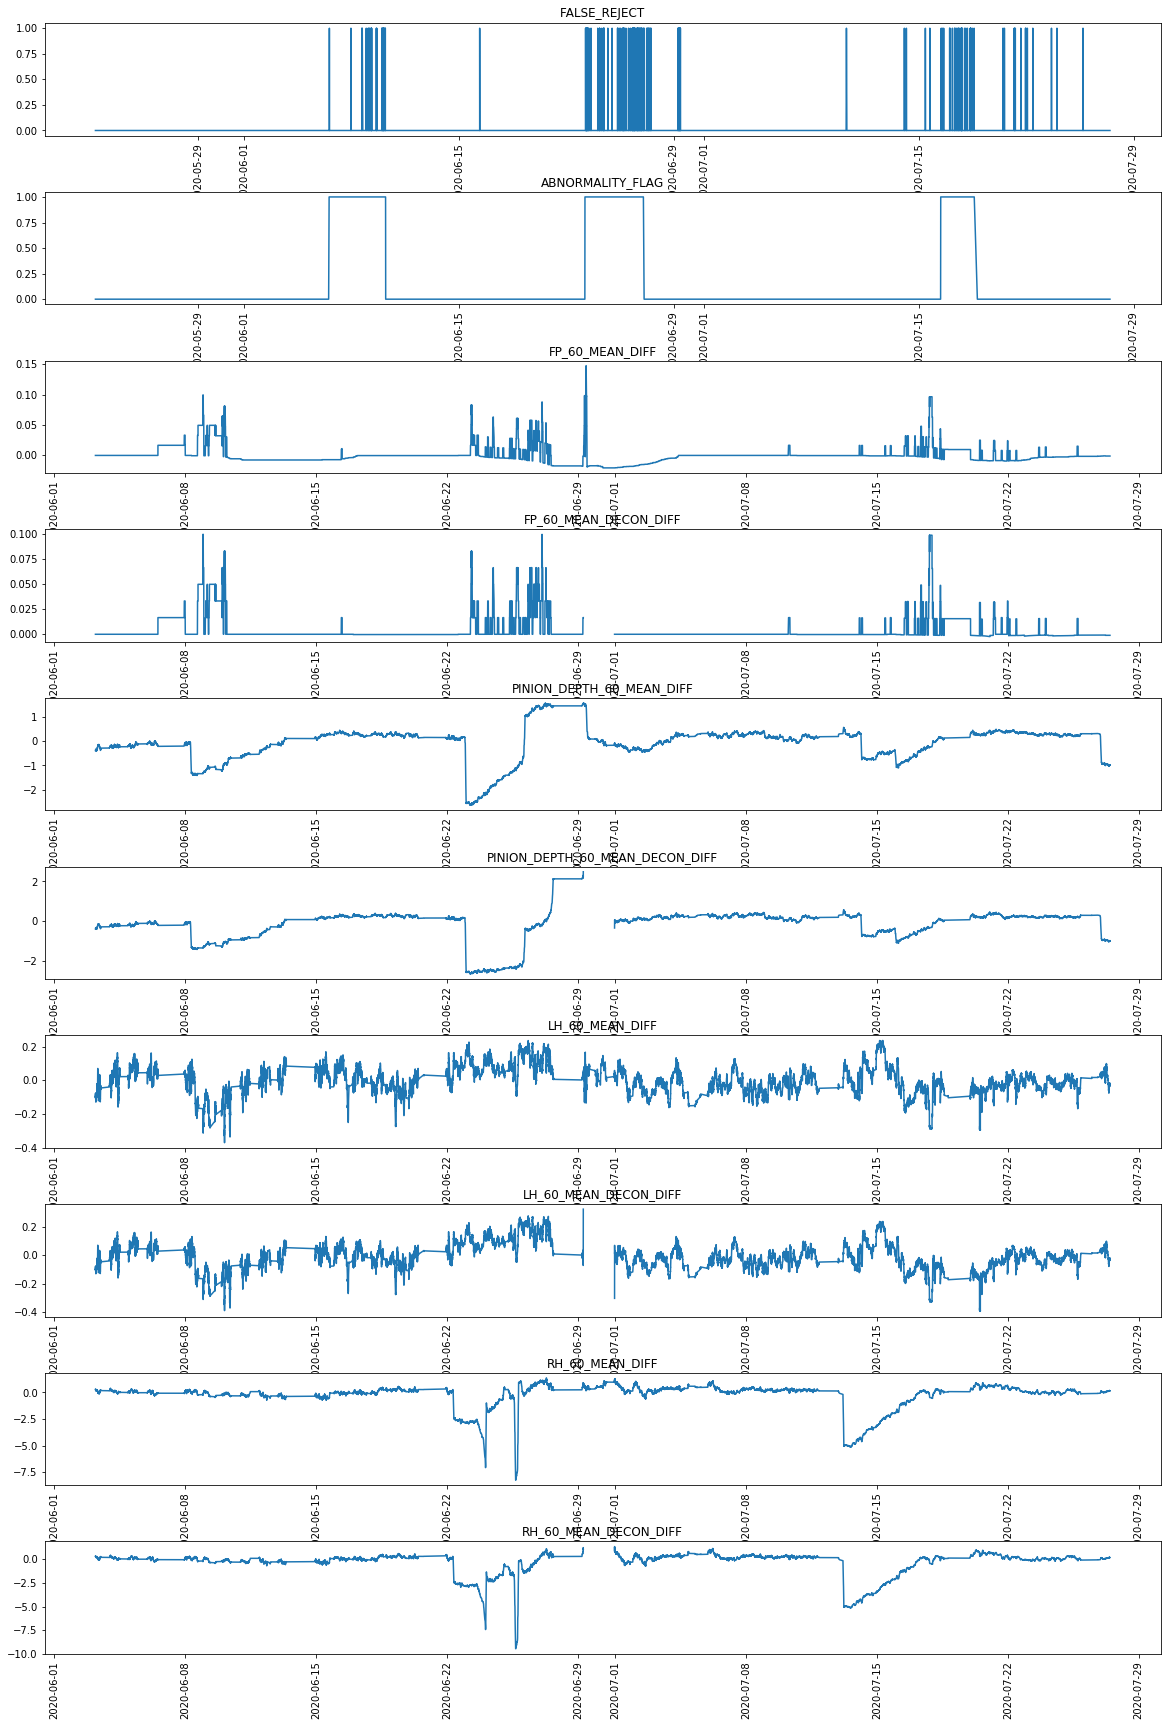

In [79]:
fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(10,1,1)
ax1.plot(df["PROD_TIMESTAMP"],df["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(10,1,2)
ax1.plot(df["PROD_TIMESTAMP"],df["ABNORMALITY_FLAG"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

columns = ["FP_60_MEAN_DIFF","FP_60_MEAN_DECON_DIFF","PINION_DEPTH_60_MEAN_DIFF","PINION_DEPTH_60_MEAN_DECON_DIFF",
          "LH_60_MEAN_DIFF","LH_60_MEAN_DECON_DIFF","RH_60_MEAN_DIFF","RH_60_MEAN_DECON_DIFF",]

for x in range(len(columns)):
    
    ax1= fig.add_subplot(10,1,x+3)
    ax1.plot(df["PROD_TIMESTAMP"],df[columns[x]])
    plt.title(columns[x])
    plt.xticks(rotation = 90,)

# Statistical Methods

## Gaussian Model Based

## Box Plot Rule

## Grubbs rule (z score) Univariate

## Student's t-test Univariate

## Hotelling t square test Multivariate

# Machine Learning Based Methods (Density Based)

### Try PCA as well

## K-Nearest Neighbour

## Local Outlier Factor(LOF)

## Isolation Forest

In [87]:
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
outliers_fraction = 0.025
# Take useful feature and standardize them 
# features = ['FALSE_REJECT','FP_30_MEAN','FP_30_SD','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN',
#           'PINION_DEPTH_30_SD','DAY_OF_WEEK','HOUR','THROUGHPUT_RATE','FP_30_MEAN_DECON_DIFF',
#              'FP_30_SD_DECON_DIFF','PINION_DEPTH_30_MEAN_DECON_DIFF',
#              'PINION_DEPTH_30_SD_DECON_DIFF']
features = ['FP_30_MEAN','FP_30_SD','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN',
          'PINION_DEPTH_30_SD','FP_30_MEAN_DECON_DIFF',
             'FP_30_SD_DECON_DIFF','PINION_DEPTH_30_MEAN_DECON_DIFF',
             'PINION_DEPTH_30_SD_DECON_DIFF']


df1 = df.dropna(subset = features)
df1.reset_index(inplace=True, drop = True)
data = df1[features]



data.dropna(inplace = True)
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df1['anomaly25'] = pd.Series(model.predict(data))
df1['anomaly25'] = df1['anomaly25'].map( {1: 0, -1: 1} )
print(df1['anomaly25'].value_counts())

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


0    40152
1     1030
Name: anomaly25, dtype: int64


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


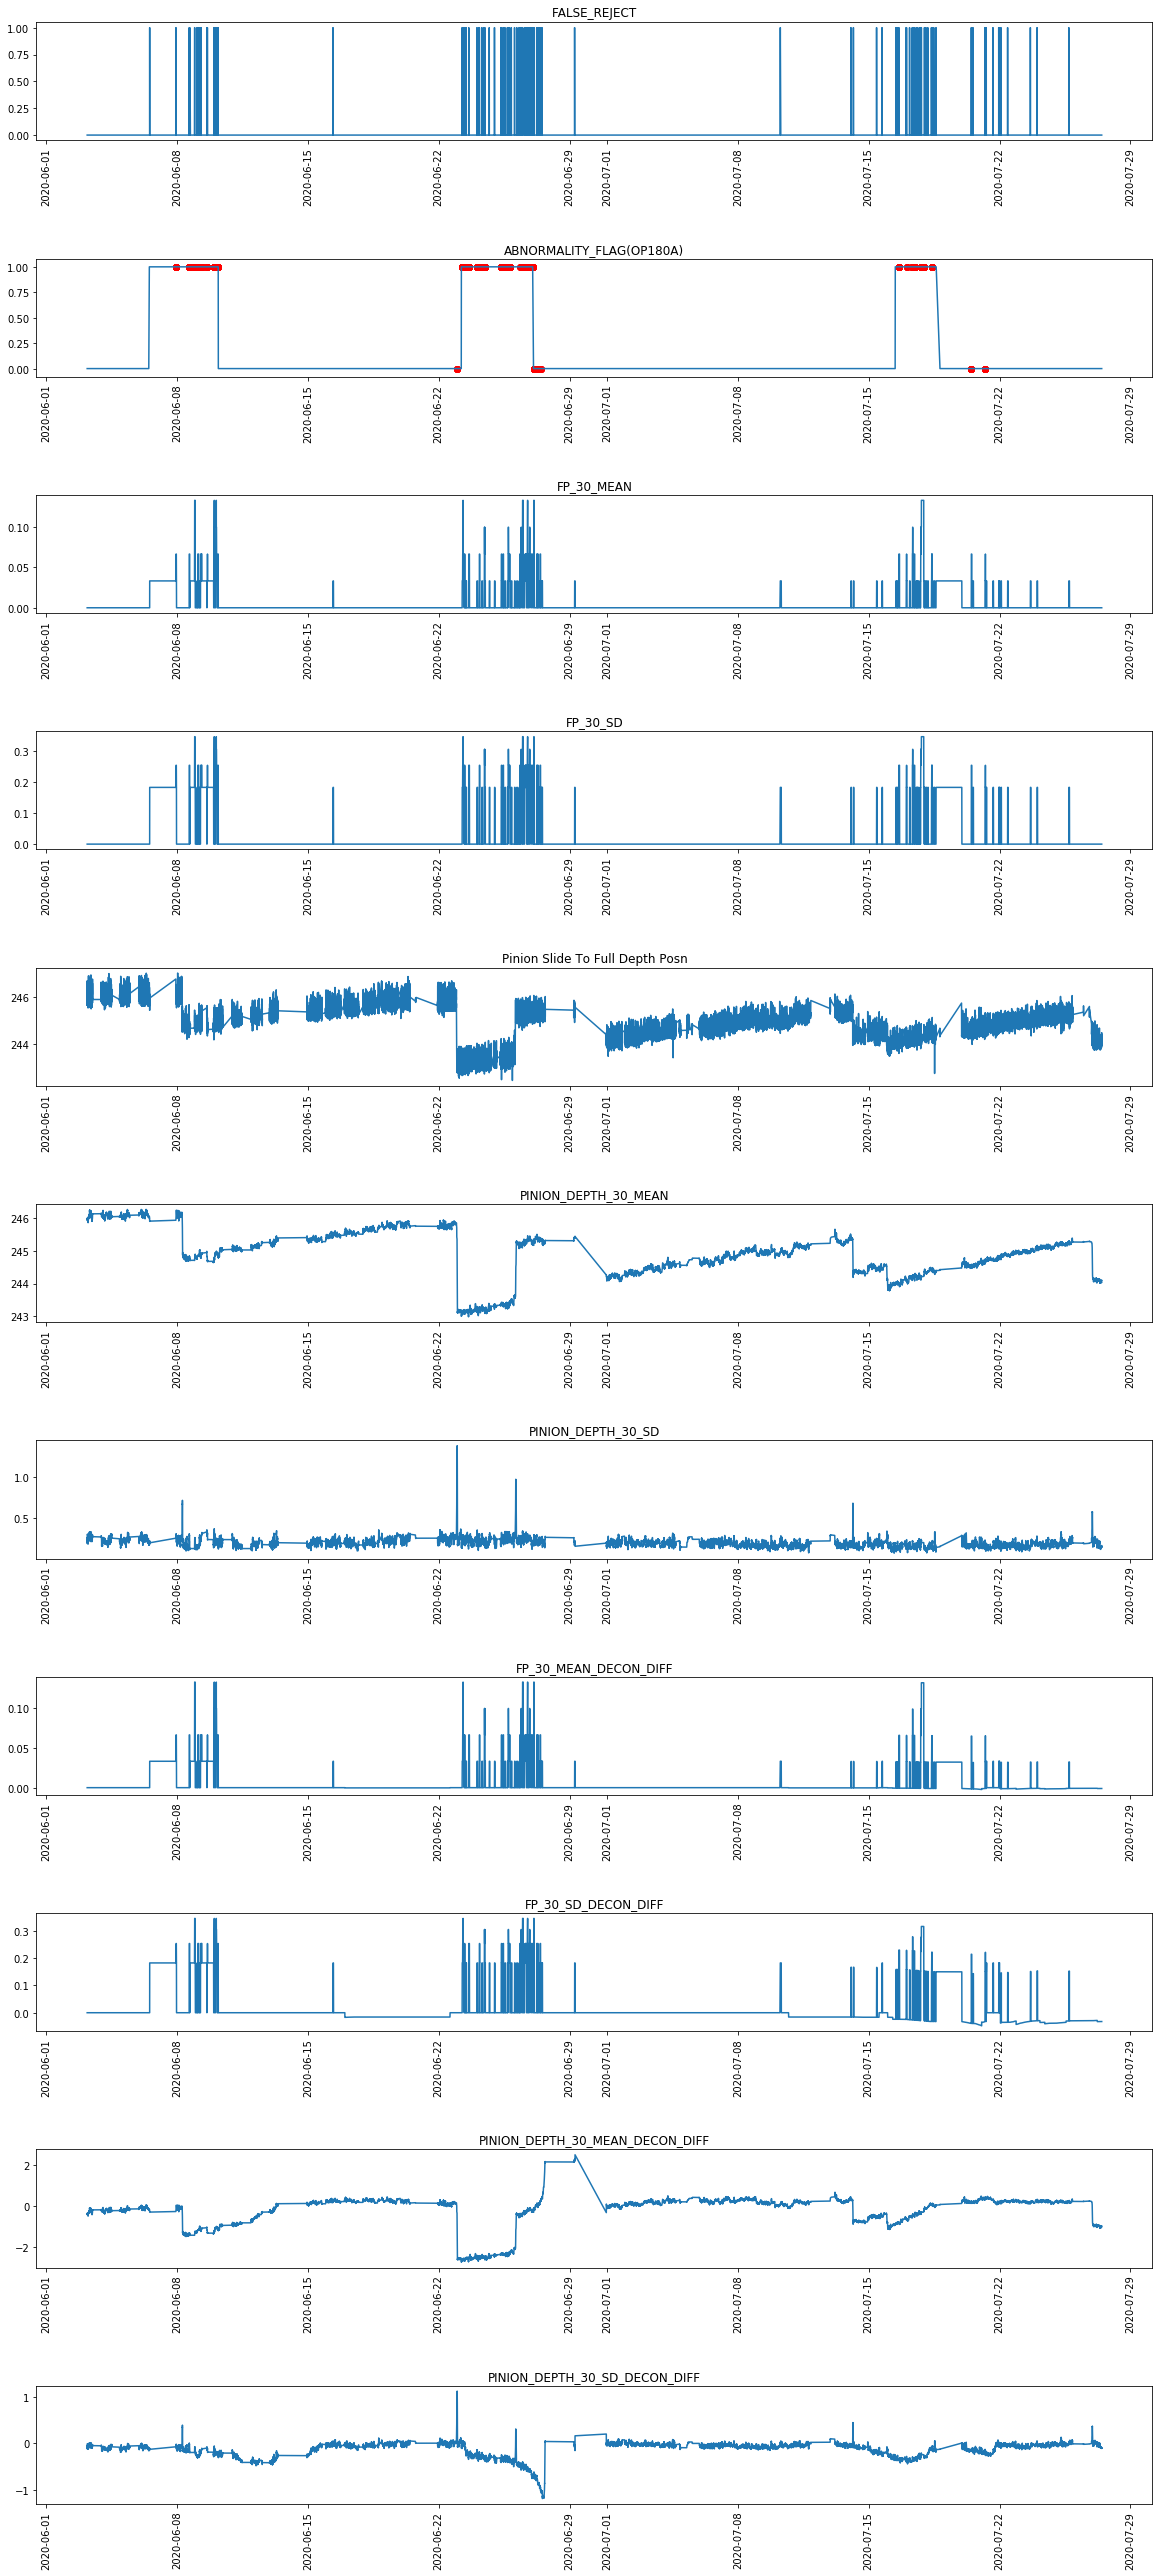

In [88]:
n_graphs = len(features)+3
fig = plt.figure(figsize = (20,50))
plt.subplots_adjust(hspace = 1)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['anomaly25'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("ABNORMALITY_FLAG(OP180A)")
plt.xticks(rotation = 90,)



for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

In [89]:
x=0

windows_name = ['1','2','3']
for y in windows_name:
    index_model = df1[(df1["ABNORMALITY_WINDOW"]==y) & (df1["anomaly25"]==1)].index.min()
    index_actual = df1[(df1["ABNORMALITY_WINDOW"]==y) & (df1["ABNORMALITY_FLAG"]==1)].index.min()
    if index_model >= index_actual:
        x=x+df1.loc[index_actual:index_model,"FALSE_REJECT"].sum()
        print(x)
print("AVG count of False Reject till Detect :" + str(x/len(windows_name)))

2
3
7
AVG count of False Reject till Detect :2.3333333333333335


# Machine Learning Based Methods (Clustering Based)

## K Means Clustering

# Machine Learning Based Methods (Support Vector Based)

## OneClassCVM

In [41]:
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
outliers_fraction = 0.015
# Take useful feature and standardize them 
# features = ['FALSE_REJECT','FP_30_MEAN','FP_30_SD','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN',
#           'PINION_DEPTH_30_SD','DAY_OF_WEEK','HOUR','THROUGHPUT_RATE','FP_30_MEAN_DECON_DIFF',
#              'FP_30_SD_DECON_DIFF','PINION_DEPTH_30_MEAN_DECON_DIFF',
#              'PINION_DEPTH_30_SD_DECON_DIFF']
features = ['FP_30_MEAN','FP_30_SD','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN',
          'PINION_DEPTH_30_SD','FP_30_MEAN_DECON_DIFF',
             'FP_30_SD_DECON_DIFF','PINION_DEPTH_30_MEAN_DECON_DIFF',
             'PINION_DEPTH_30_SD_DECON_DIFF']


df1 = df.dropna(subset = features)
df1.reset_index(inplace=True, drop = True)
data = df1[features]


min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df1['anomaly26'] = pd.Series(model.predict(data))
df1['anomaly26'] = df1['anomaly26'].map( {1: 0, -1: 1} )
print(df1['anomaly26'].value_counts())

0    40596
1      586
Name: anomaly26, dtype: int64


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


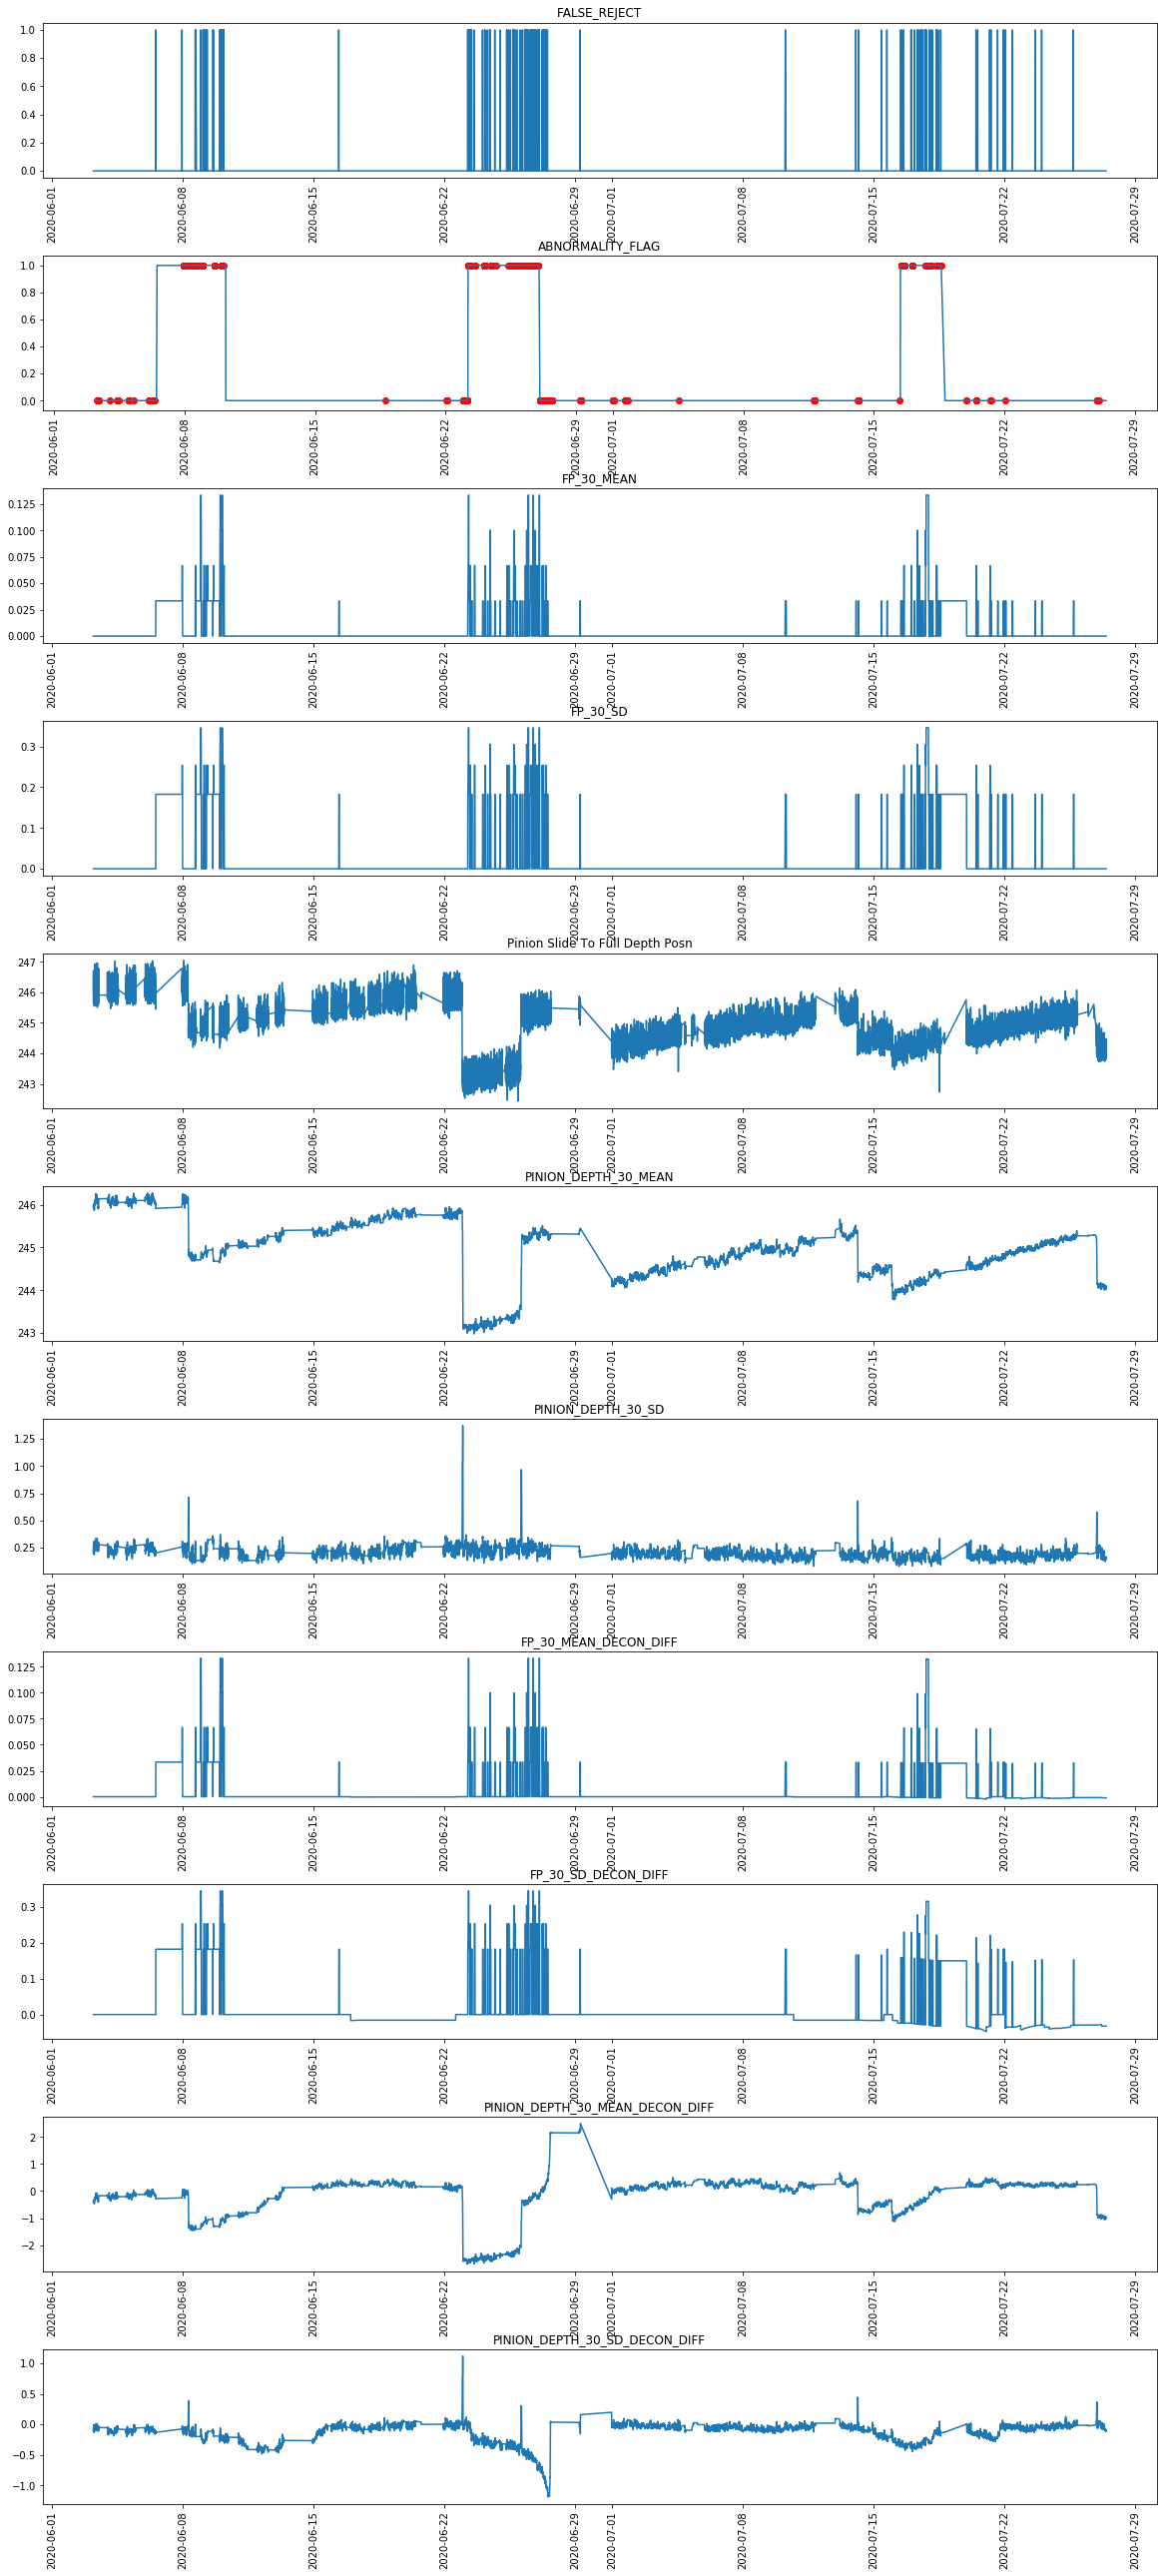

In [42]:
n_graphs = len(features)+3
fig = plt.figure(figsize = (20,50))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['anomaly26'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)



for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

# Time Series Forcasting and Deviation based

## LSTM

## ARIMA

# Archieve

## Raw Plots

(array([737577., 737584., 737591., 737598., 737605., 737607., 737614.,
        737621., 737628., 737635.]), <a list of 10 Text xticklabel objects>)

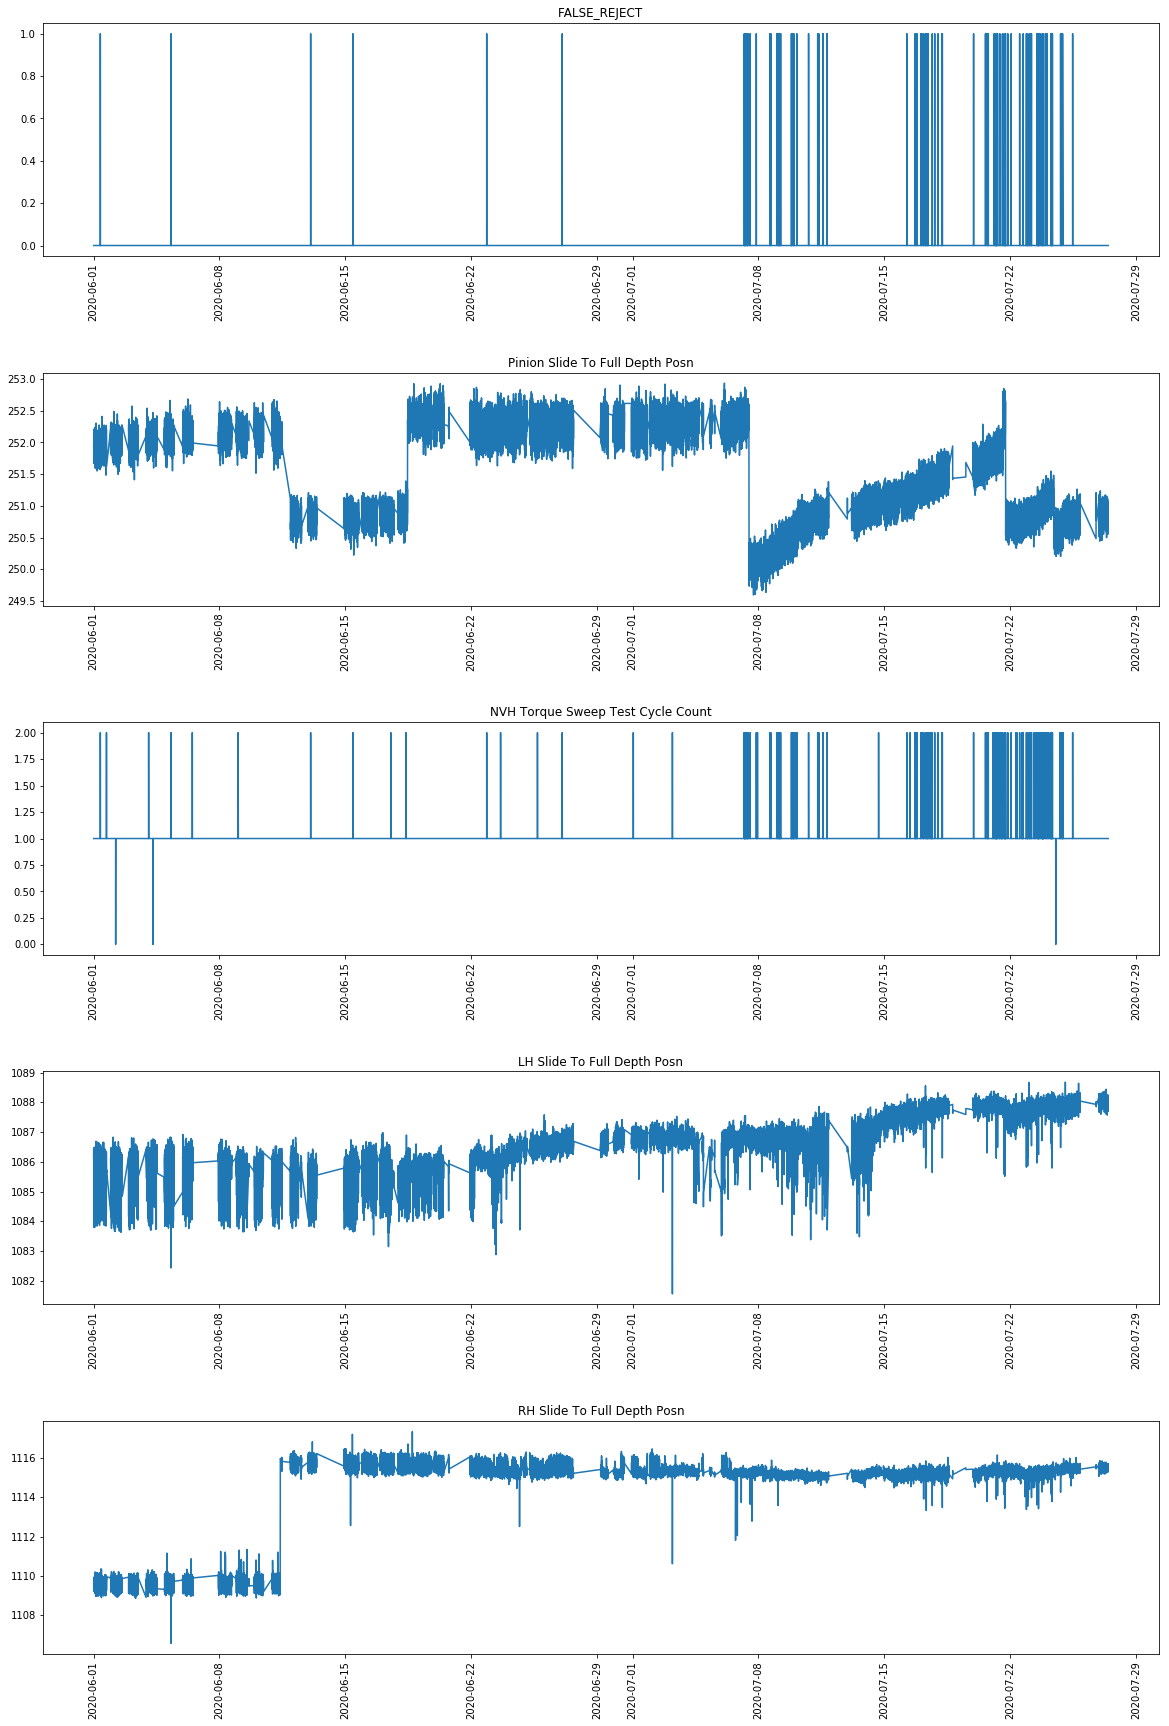

In [21]:
df1= df
# df1= df[(df["PROD_TIMESTAMP"]>=pd.datetime(2020,6,22))&(df["PROD_TIMESTAMP"]<=pd.datetime(2020,6,25))]
df1= df[(df["PROD_TIMESTAMP"]>=pd.datetime(2020,6,1))&(df["PROD_TIMESTAMP"]<=pd.datetime(2020,7,30))]

fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["Pinion Slide To Full Depth Posn"])
plt.title("Pinion Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,3)
ax1.plot(df1["PROD_TIMESTAMP"],df1["NVH Torque Sweep Test Cycle Count"])
plt.title("NVH Torque Sweep Test Cycle Count")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,4)
ax1.plot(df1["PROD_TIMESTAMP"],df1["LH Slide To Full Depth Posn"])
plt.title("LH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,5)
ax1.plot(df1["PROD_TIMESTAMP"],df1["RH Slide To Full Depth Posn"])
plt.title("RH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


#OPEN
# df_tmp = pd.DataFrame(df_account[df_account.DATE_CLOSED.isna()][list1].count()/len(df_account[df_account.DATE_CLOSED.isna()])).reset_index()
# df_tmp.columns = ["COLUMN_NAME","FILL_RATE"]
# ax2= fig.add_subplot(4,1,2)
# ax2.bar(df_tmp.COLUMN_NAME,df_tmp.FILL_RATE)
# plt.title("FILL Rate:OPEN")
# for i, txt in enumerate(df_tmp.FILL_RATE):
#     plt.annotate("{:.0f}".format(txt*100), ((i-0.25, df_tmp.FILL_RATE[i]+0.01)))
# plt.xticks(rotation = 90)
# plt.ylim(0,1.1)


### Group on hourly level and plot

In [22]:
df["PROD_HOUR"]=df["PROD_TIMESTAMP"].apply(lambda x: pd.datetime(x.year,x.month,x.day,x.hour))

In [23]:
df_hour = df[["PROD_HOUR","LH Slide To Full Depth Posn","NVH Torque Sweep Test Cycle Count","Pinion Slide To Full Depth Posn","RH Slide To Full Depth Posn","FALSE_REJECT"]].groupby("PROD_HOUR").agg(["mean"])

df_hour.columns = [' '.join(col).strip() for col in df_hour.columns.values]

df_hour.reset_index(inplace = True)

(array([737574., 737577., 737591., 737605., 737607., 737621., 737635.]),
 <a list of 7 Text xticklabel objects>)

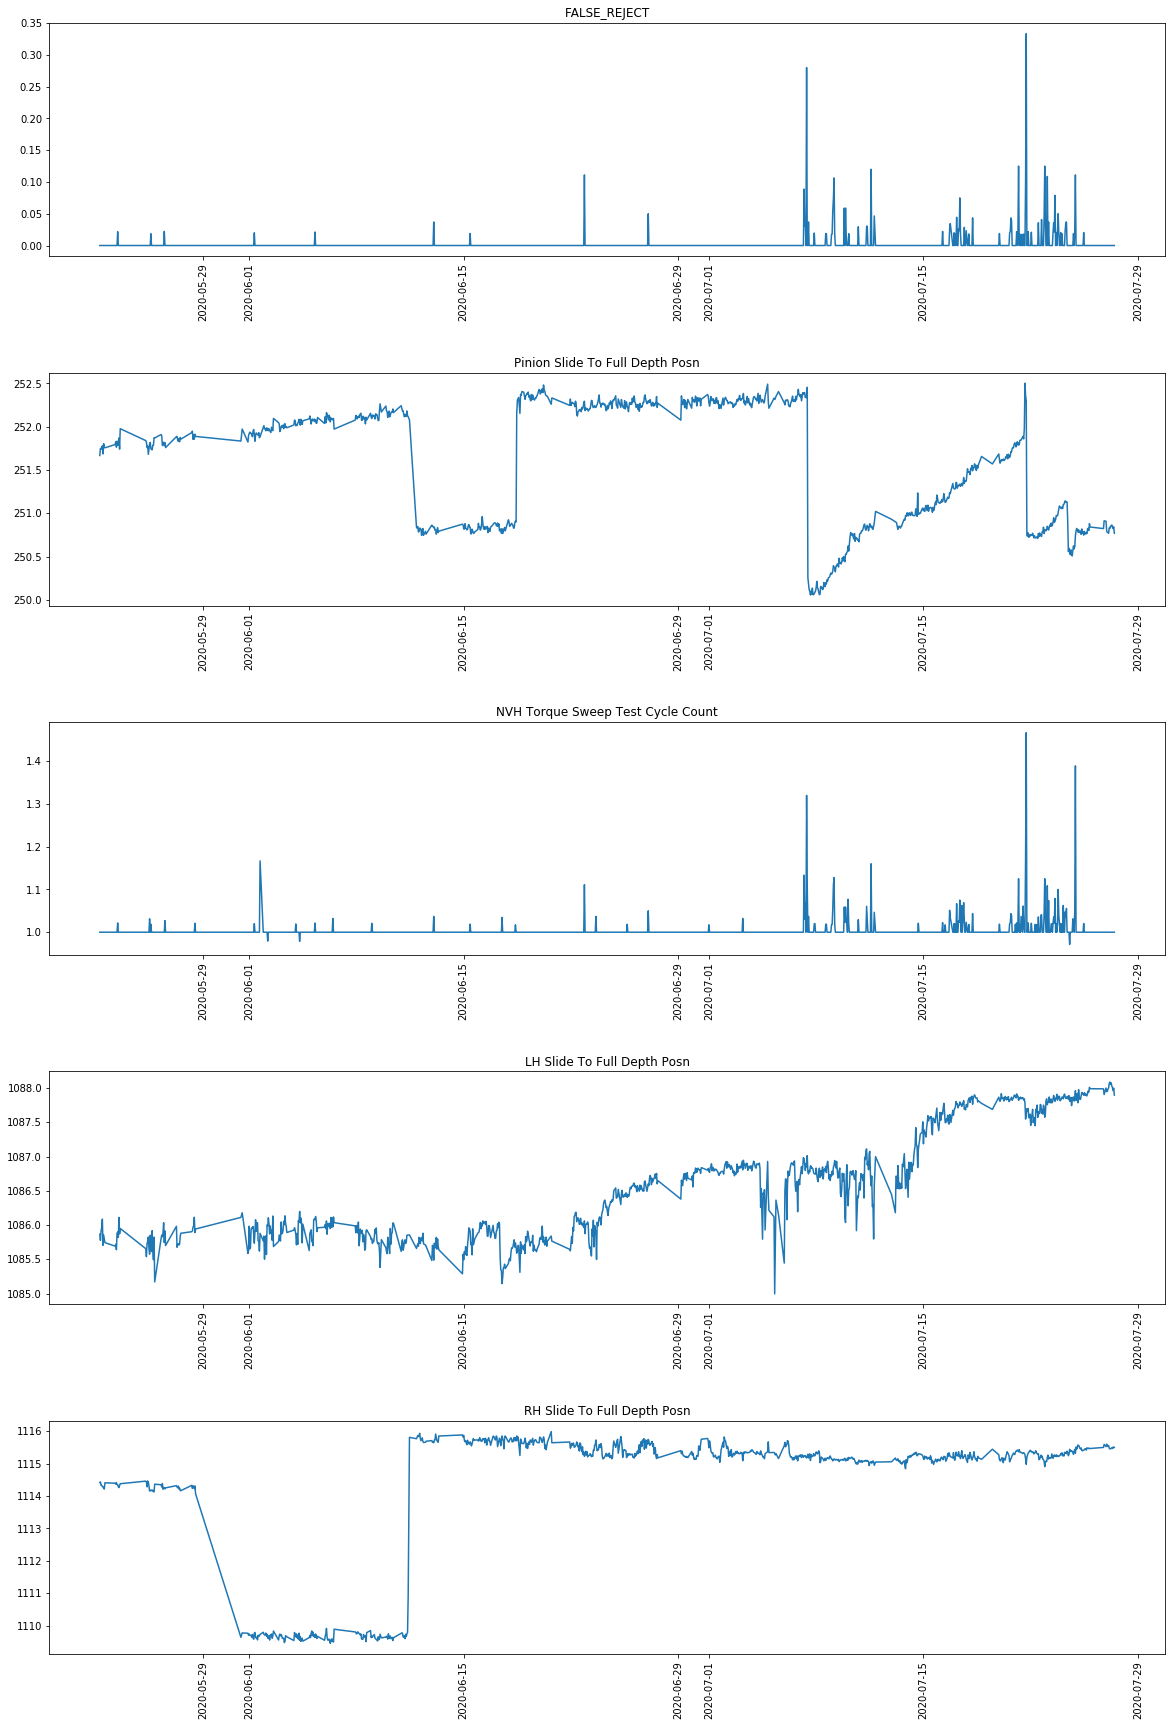

In [24]:
df1= df_hour[df_hour["PROD_HOUR"]>=pd.datetime(2020,5,20)]


fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_HOUR"],df1["FALSE_REJECT mean"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_HOUR"],df1["Pinion Slide To Full Depth Posn mean"])
plt.title("Pinion Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,3)
ax1.plot(df1["PROD_HOUR"],df1["NVH Torque Sweep Test Cycle Count mean"])
plt.title("NVH Torque Sweep Test Cycle Count")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,4)
ax1.plot(df1["PROD_HOUR"],df1["LH Slide To Full Depth Posn mean"])
plt.title("LH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,5)
ax1.plot(df1["PROD_HOUR"],df1["RH Slide To Full Depth Posn mean"])
plt.title("RH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


#OPEN
# df_tmp = pd.DataFrame(df_account[df_account.DATE_CLOSED.isna()][list1].count()/len(df_account[df_account.DATE_CLOSED.isna()])).reset_index()
# df_tmp.columns = ["COLUMN_NAME","FILL_RATE"]
# ax2= fig.add_subplot(4,1,2)
# ax2.bar(df_tmp.COLUMN_NAME,df_tmp.FILL_RATE)
# plt.title("FILL Rate:OPEN")
# for i, txt in enumerate(df_tmp.FILL_RATE):
#     plt.annotate("{:.0f}".format(txt*100), ((i-0.25, df_tmp.FILL_RATE[i]+0.01)))
# plt.xticks(rotation = 90)
# plt.ylim(0,1.1)


### Group on 6 hourly level and plot

In [25]:
df["PROD_HOUR"]=df["PROD_TIMESTAMP"].apply(lambda x: pd.datetime(x.year,x.month,x.day,math.floor(x.hour/6)*6))

In [26]:
df_hour = df[["PROD_HOUR","LH Slide To Full Depth Posn","NVH Torque Sweep Test Cycle Count","Pinion Slide To Full Depth Posn","RH Slide To Full Depth Posn","FALSE_REJECT"]].groupby("PROD_HOUR").agg(["mean"])

df_hour.columns = [' '.join(col).strip() for col in df_hour.columns.values]

df_hour.reset_index(inplace = True)

(array([737574., 737577., 737591., 737605., 737607., 737621., 737635.]),
 <a list of 7 Text xticklabel objects>)

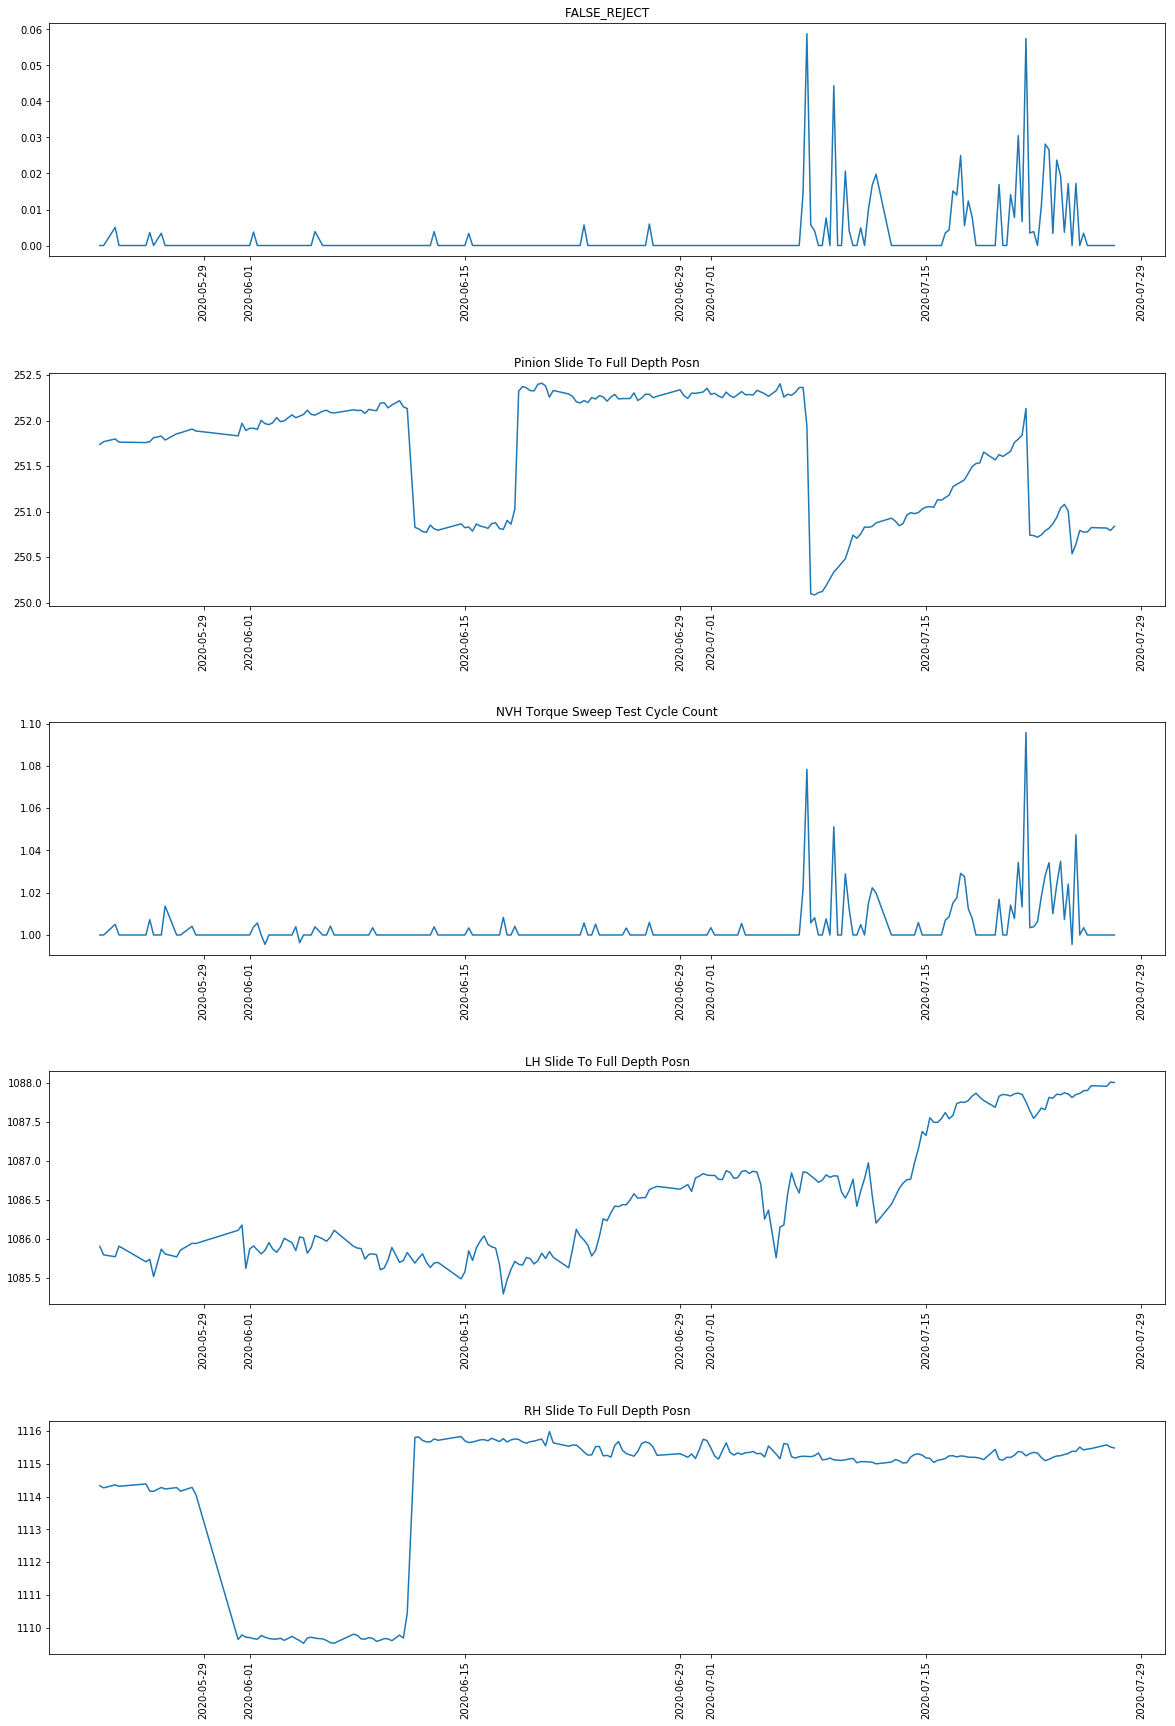

In [27]:
df1= df_hour[df_hour["PROD_HOUR"]>=pd.datetime(2020,5,20)]


fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_HOUR"],df1["FALSE_REJECT mean"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_HOUR"],df1["Pinion Slide To Full Depth Posn mean"])
plt.title("Pinion Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,3)
ax1.plot(df1["PROD_HOUR"],df1["NVH Torque Sweep Test Cycle Count mean"])
plt.title("NVH Torque Sweep Test Cycle Count")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,4)
ax1.plot(df1["PROD_HOUR"],df1["LH Slide To Full Depth Posn mean"])
plt.title("LH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,5)
ax1.plot(df1["PROD_HOUR"],df1["RH Slide To Full Depth Posn mean"])
plt.title("RH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


#OPEN
# df_tmp = pd.DataFrame(df_account[df_account.DATE_CLOSED.isna()][list1].count()/len(df_account[df_account.DATE_CLOSED.isna()])).reset_index()
# df_tmp.columns = ["COLUMN_NAME","FILL_RATE"]
# ax2= fig.add_subplot(4,1,2)
# ax2.bar(df_tmp.COLUMN_NAME,df_tmp.FILL_RATE)
# plt.title("FILL Rate:OPEN")
# for i, txt in enumerate(df_tmp.FILL_RATE):
#     plt.annotate("{:.0f}".format(txt*100), ((i-0.25, df_tmp.FILL_RATE[i]+0.01)))
# plt.xticks(rotation = 90)
# plt.ylim(0,1.1)


## Anamoly Score implementation

### Using Robust Random cut Forest

In [28]:
sin = df[(df["PROD_TIMESTAMP"]>=pd.datetime(2020,6,1))&(df["PROD_TIMESTAMP"]<=pd.datetime(2020,7,30))][["PROD_TIMESTAMP","FALSE_REJECT"]]

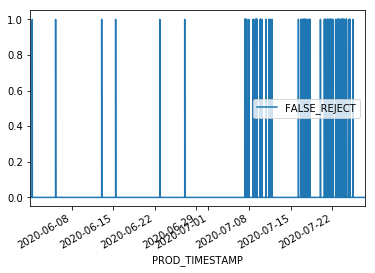

In [29]:
sin.plot(x="PROD_TIMESTAMP",y="FALSE_REJECT")

In [30]:
import rrcf

num_trees = 40
shingle_size =1500
tree_size = 256

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

In [31]:
points = rrcf.shingle(sin["FALSE_REJECT"], size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size...
        if len(tree.leaves) > tree_size:
            # Drop the oldest point (FIFO)
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point...
        new_codisp = tree.codisp(index)
        # And take the average over all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += new_codisp / num_trees

KeyboardInterrupt: 

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# fig, ax1 = plt.subplots(figsize=(10, 5))


# color = 'tab:red'
# ax1.set_ylabel('Data', color=color, size=14)
# ax1.plot(sin, color=color)
# ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
# ax1.set_ylim(0,5)
# ax2 = ax1.twinx()
# color = 'tab:blue'
# ax2.set_ylabel('CoDisp', color=color, size=14)
# ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
# ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
# ax2.grid('off')
# ax2.set_ylim(0, 500)
# plt.title('False Reject (red) and anomaly score (blue)', size=14)

In [ ]:

fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(sin["PROD_TIMESTAMP"],sin["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,2)
ax1.plot(sin["PROD_TIMESTAMP"][0:len(sin)-shingle_size+1],pd.Series(avg_codisp))
plt.title("Anamoly Index")
plt.xticks(rotation = 90,)


## Using distribution comparison 2 Sample KS Statistics

### False Reject

In [ ]:
# df.reset_index(inplace = True)
df["DIFF"] = ""

# x= 20000
b_window = 6000  #Remove identified anamolies
c_window = 30


# df.shape[0]
start = time.time()

for x in range(b_window,df.shape[0]):
    
    base_obs = list(df["FALSE_REJECT"][max(0,x-b_window-c_window):max(0,x-c_window)])
    current_obs = list(df["FALSE_REJECT"][max(0,x-c_window):x])
    ks_value = ks_2samp(base_obs,current_obs)
#     ks_value = ks_2samp([0] * 10000,current_obs)
    df.loc[df.index[x],"DIFF"] = 1-ks_value.pvalue

print (time.time()-start)

In [ ]:
df1 = df.dropna(subset = ['DIFF'])
df1 = df[df["DIFF"]!=""]
# df1=df1[(df1["PROD_TIMESTAMP"] >= pd.datetime(2020,6,22))&(df1["PROD_TIMESTAMP"] <= pd.datetime(2020,6,30))]
fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["DIFF"])
plt.title("Anamoly Index")
plt.xticks(rotation = 90,)


### Pinion Slide To Full Depth Posn

In [ ]:
# df.reset_index(inplace = True)
df["DIFF_VAR1"] = ""

# x= 20000
b_window = 6000
c_window = 30


# df.shape[0]
start = time.time()

for x in range(b_window,df.shape[0]):
    
    base_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
    current_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-c_window):x])
    ks_value = ks_2samp(base_obs,current_obs)
#     ks_value = ks_2samp([0] * 10000,current_obs)
    df.loc[df.index[x],"DIFF_VAR1"] = 1-ks_value.pvalue

print (time.time()-start)

In [ ]:
df1 = df.dropna(subset = ['DIFF_VAR1'])
df1 = df[df["DIFF_VAR1"]!=""]
df1=df1[(df1["PROD_TIMESTAMP"] >= pd.datetime(2020,6,22))&(df1["PROD_TIMESTAMP"] <= pd.datetime(2020,6,30))]
fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["DIFF_VAR1"])
plt.title("Anamoly Index")
plt.xticks(rotation = 90,)


## Using distribution comparison Chi Square

### False Reject

In [ ]:
# df.reset_index(inplace = True)

# x= 20000
b_window = 6000
c_window = 500
gap = 6000


start = time.time()

for x in range(b_window+gap,df.shape[0]):
    base_obs = list(df["FALSE_REJECT"][max(0,x-b_window-c_window-gap):max(0,x-c_window-gap)])
    current_obs = list(df["FALSE_REJECT"][max(0,x-c_window):x])
#     table = [[base_obs.count(0), base_obs.count(1)],
#         [current_obs.count(0),current_obs.count(1)]]

    table = [[2000, 60],
        [current_obs.count(0),current_obs.count(1)]]

    
    try:

        stat, p, dof, expected = chi2_contingency(table)
#     ks_value = ks_2samp(base_obs,current_obs)
#     ks_value = ks_2samp([0] * 10000,current_obs)
        df.loc[df.index[x],"CHI_SQ_1"] = 1-p
    except:
        df.loc[df.index[x],"CHI_SQ_1"] = 0
        
print (time.time()-start)

In [ ]:
df1 = df.dropna(subset = ['CHI_SQ_1'])
df1 = df[df["CHI_SQ_1"]!=""]
# df1=df1[(df1["PROD_TIMESTAMP"] >= pd.datetime(2020,6,22))&(df1["PROD_TIMESTAMP"] <= pd.datetime(2020,6,30))]
fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["CHI_SQ_1"])
plt.title("Anamoly Index")
plt.xticks(rotation = 90,)


In [ ]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(df_dod["PROD_DAY"],df_dod["FALSE_REJECT count"], label = 'FALSE_REJECT count')
plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT count')
plt.legend(loc="best")
plt.xticks(rotation = 90,)
ax2 = ax1.twinx()
ax2.plot(df_dod["PROD_DAY"],df_dod["FALSE_REJECT sum"],color='red', linewidth=4, markersize=12, label = 'FALSE_REJECT sum')
plt.title("DOD Count and False Rejects")
plt.legend(loc="best")


plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT sum')

plt.show()
# ax1.plot()

# df_dod.plot(x="PROD_DAY", y = ["FALSE_REJECT sum","FALSE_REJECT count"])